In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import seaborn as sns
import statsmodels.api as sm
import ISLP as islp
from ISLP.models import summarize
from scipy import stats
import matplotlib.pyplot as plt
sns.set_theme()

## 01 Getting data

In [2]:
ad = pd.read_csv('../data/Advertising.csv', index_col=0)

In [3]:
ad.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [4]:
ad.shape

(200, 4)

In [5]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


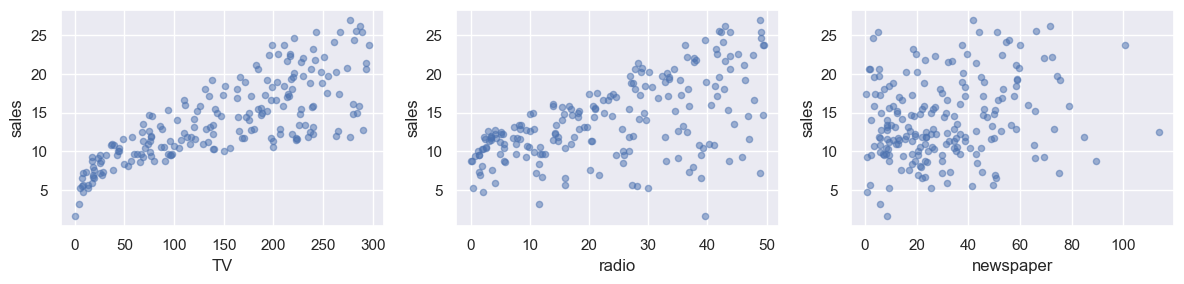

In [6]:
# Let's plot the data to see if there are any relationships between the variables
# and the sales. We will plot the scatter plots of the sales with each of the
# advertising channels.
fig, ax = subplots(1, 3, figsize=(12, 3))
ad.plot.scatter(x='TV', y='sales', ax=ax[0], alpha=0.5)
ad.plot.scatter(x='radio', y='sales', ax=ax[1], alpha=0.5)
ad.plot.scatter(x='newspaper', y='sales', ax=ax[2], alpha=0.5)
fig.tight_layout()

## 02 Simple Linear Regression

### 01 Estimating the coefficients

Channel: TV - Intercept: 7.0326, Slope: 0.0475
Channel: radio - Intercept: 9.3116, Slope: 0.2025
Channel: newspaper - Intercept: 12.3514, Slope: 0.0547


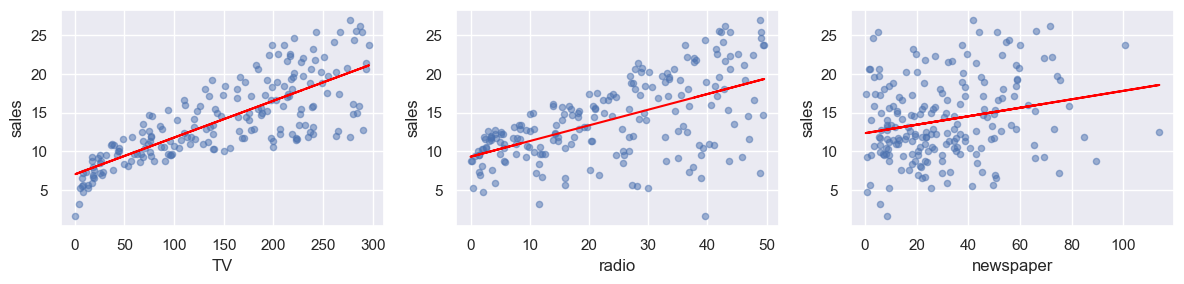

In [7]:
# Let's fit a simple linear regression model to the data separately for each of the advertising channels.
# We will use the statsmodels library to fit the models. We will also plot the fitted models on top of the
# scatter plots. We will also print the coefficients of the models.
fig, ax = subplots(1, 3, figsize=(12, 3))
for i, channel in enumerate(['TV', 'radio', 'newspaper']):
    X = ad[channel]
    X = sm.add_constant(X)
    y = ad['sales']
    model = sm.OLS(y, X).fit()
    # Print the channel and the coefficients of the model
    print(f'Channel: {channel} - Intercept: {model.params['const']:.4f}, Slope: {model.params[channel]:.4f}')
    ad.plot.scatter(x=channel, y='sales', ax=ax[i], alpha=0.5)
    ax[i].plot(ad[channel], model.fittedvalues, color='red')
fig.tight_layout();

In [8]:
# Let's compute coefficients of regression manually using the formula for simple linear regression model.
# Only for TV channel. We use normal equations to compute the coefficients in non-matrix notation.
X = ad['TV'].to_numpy()
y = ad['sales'].to_numpy()
# Compute the coefficients of the model using normal equations in non-matrix notation
beta1 = np.sum((X - np.mean(X)) * (y - np.mean(y))) / np.sum((X - np.mean(X))**2)
beta0 = np.mean(y) - beta1 * np.mean(X)
print(f'Channel: TV - Intercept: {beta0:.4f}, Slope: {beta1:.4f}')

Channel: TV - Intercept: 7.0326, Slope: 0.0475


### 02 Accuracy of the Coefficient

In [9]:
# Let's compute the 95% confidence intervals for the coefficients of the model for the TV channel.
# We will use the statsmodels library to compute the confidence intervals. Then we will compute them manually.
X = ad['TV']
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the confidence intervals of the coefficients of the model
print('Statsmodels computation') 
# Round the confidence intervals to 4 decimal places
ci_beta0_stats = np.round(model.conf_int().loc['const'].to_numpy(), 4)
ci_beta1_stats = np.round(model.conf_int().loc['TV'].to_numpy(), 4)
print(f'Channel: TV - Intercept: {ci_beta0_stats}')
print(f'Channel: TV - Slope: {ci_beta1_stats}')

# Compute the confidence intervals of the coefficients of the model manually
n = ad.shape[0]
X = ad['TV'].to_numpy()
y = ad['sales'].to_numpy()
# Compute the standard error of the residuals
residuals = y - (model.params['const'] + model.params['TV'] * X)
sigma = np.sqrt(np.sum(residuals**2) / (n - 2))
# Compute the standard error of the coefficients
se_beta0 = sigma * np.sqrt(1 / n + np.mean(X)**2 / np.sum((X - np.mean(X))**2))
se_beta1 = sigma / np.sqrt(np.sum((X - np.mean(X))**2))
# Compute the t-value for the confidence intervals
t_value = stats.t.ppf(0.975, n - 2)
# Compute the confidence intervals
ci_beta0 = model.params['const'] + np.array([-1, 1]) * t_value * se_beta0
ci_beta1 = model.params['TV'] + np.array([-1, 1]) * t_value * se_beta1
# Round the confidence intervals to 4 decimal places
ci_beta0 = np.round(ci_beta0, 4)
ci_beta1 = np.round(ci_beta1, 4)
print()
print('Manual computation') 
print(f'Channel: TV - Intercept: {ci_beta0}')
print(f'Channel: TV - Slope: {ci_beta1}')

Statsmodels computation
Channel: TV - Intercept: [6.1297 7.9355]
Channel: TV - Slope: [0.0422 0.0528]

Manual computation
Channel: TV - Intercept: [6.1297 7.9355]
Channel: TV - Slope: [0.0422 0.0528]


In [10]:
# Let's now test the null hypothesis that the coefficients of the model for the TV channel is zero.
# We will use the statsmodels library to compute the p-values. Then we will compute them manually.
X = ad['TV']
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the p-values of the coefficients of the model
print('Statsmodels computation')
# Round the p-values to 4 decimal places
p_value_beta0_stats = np.round(model.pvalues['const'], 4)
p_value_beta1_stats = np.round(model.pvalues['TV'], 4)
# Print coefficient name , coefficient value (4 digits), std error (4 digits), t-value (2 digits), p-value (4 digits)
print(f'Channel: TV - Intercept: {model.params["const"]:.4f}, {model.bse["const"]:.4f}, {model.tvalues["const"]:.2f}, {p_value_beta0_stats:.4f}')
print(f'Channel: TV - Slope: {model.params["TV"]:.4f}, {model.bse["TV"]:.4f}, {model.tvalues["TV"]:.2f}, {p_value_beta1_stats:.4f}')

# Compute the p-values of the coefficients of the model manually
n = ad.shape[0]
X = ad['TV'].to_numpy()
y = ad['sales'].to_numpy()
# Compute the standard error of the residuals
residuals = y - (model.params['const'] + model.params['TV'] * X)
sigma = np.sqrt(np.sum(residuals**2) / (n - 2))
# Compute the standard error of the coefficients
se_beta0 = sigma * np.sqrt(1 / n + np.mean(X)**2 / np.sum((X - np.mean(X))**2))
se_beta1 = sigma / np.sqrt(np.sum((X - np.mean(X))**2))
# Compute the t-value for the p-values
t_value_beta0 = model.params['const'] / se_beta0
t_value_beta1 = model.params['TV'] / se_beta1
# Compute the p-values
p_value_beta0 = 2 * (1 - stats.t.cdf(np.abs(t_value_beta0), n - 2))
p_value_beta1 = 2 * (1 - stats.t.cdf(np.abs(t_value_beta1), n - 2))
# Round the p-values to 4 decimal places
p_value_beta0 = np.round(p_value_beta0, 4)
p_value_beta1 = np.round(p_value_beta1, 4)
print()
print('Manual computation')
print(f'Channel: TV - Intercept: {model.params["const"]:.4f}, {model.bse["const"]:.4f}, {t_value_beta0:.2f}, {p_value_beta0:.4f}')
print(f'Channel: TV - Slope: {model.params["TV"]:.4f}, {model.bse["TV"]:.4f}, {t_value_beta1:.2f}, {p_value_beta1:.4f}')

Statsmodels computation
Channel: TV - Intercept: 7.0326, 0.4578, 15.36, 0.0000
Channel: TV - Slope: 0.0475, 0.0027, 17.67, 0.0000

Manual computation
Channel: TV - Intercept: 7.0326, 0.4578, 15.36, 0.0000
Channel: TV - Slope: 0.0475, 0.0027, 17.67, 0.0000


In [11]:
summarize(model)

,coef,std err,t,P>|t|
const,7.0326,0.458,15.360,0.0
TV,0.0475,0.003,17.668,0.0


### 03 Accuracy of the Model

In [12]:
# Let's compute the RSE of the model for the TV channel. We will use the statsmodels library to compute the RSE.
# Then we will compute it manually. We will also compute the R^2 of the model in both ways.
X = ad['TV']
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the RSE of the model
print('Statsmodels computation')
# Round the RSE to 4 decimal places
rse_stats = np.round(np.sqrt(model.mse_resid), 4)
print(f'RSE: {rse_stats}')
# Round the R^2 to 4 decimal places
r2_stats = np.round(model.rsquared, 4)
print(f'R^2: {r2_stats}')

# Compute the RSE of the model manually
n = ad.shape[0]
X = ad['TV'].to_numpy()
y = ad['sales'].to_numpy()
# Compute the residuals
residuals = y - (model.params['const'] + model.params['TV'] * X)
# Compute the RSE of the model
rse = np.sqrt(np.sum(residuals**2) / (n - 2))
# Round the RSE to 4 decimal places
rse = np.round(rse, 4)
# Compute the R^2 of the model
r2 = 1 - np.sum(residuals**2) / np.sum((y - np.mean(y))**2)
# Round the R^2 to 4 decimal places
r2 = np.round(r2, 4)
print()
print('Manual computation')
print(f'RSE: {rse}')
print(f'R^2: {r2}')

Statsmodels computation
RSE: 3.2587
R^2: 0.6119

Manual computation
RSE: 3.2587
R^2: 0.6119


## 03 Multiple Linear Egression

In [13]:
# Let's fit a multiple linear regression model to the data using all the advertising channels.
# We will use the statsmodels library to fit the model. We will also print the coefficients of the model.
X = ad[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the coefficients of the model
islp.models.summarize(model)

,coef,std err,t,P>|t|
const,2.9389,0.312,9.422,0.00
TV,0.0458,0.001,32.809,0.00
radio,0.1885,0.009,21.893,0.00
newspaper,-0.0010,0.006,-0.177,0.86


In [14]:
# Let's compute correlation matrix of the data to see if there are any relationships between the variables.
correlation = ad.corr()
print(correlation)

                 TV     radio  newspaper     sales
TV         1.000000  0.054809   0.056648  0.782224
radio      0.054809  1.000000   0.354104  0.576223
newspaper  0.056648  0.354104   1.000000  0.228299
sales      0.782224  0.576223   0.228299  1.000000


In [16]:
# let's compute F-statistic for the multiple linear regression model from statsmodel.
X = ad[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the F-statistic of the model
print('Statsmodels computation')
# Round the F-statistic to 4 decimal places
f_statistic_stats = np.round(model.fvalue, 2)
print(f'F-statistic: {f_statistic_stats}')

Statsmodels computation
F-statistic: 570.27


In [25]:
# Let's build models with and without the newspaper channel and compare them using the R^2.
# We will use the statsmodels library to compute the R^2. We also compute RSE.

# Model with TV and radio channels
X = ad[['TV', 'radio']]
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the R^2 of the model
print('Model with TV and radio channels')
# Round the R^2 to 4 decimal places
r2_stats = np.round(model.rsquared, 5)
print(f'R^2: {r2_stats}')
# Compute RSE of the model
residuals = model.resid
rse = np.sqrt(np.sum(residuals**2) / (ad.shape[0] - 2 - 1))
# Round the RSE to 4 decimal places
rse = np.round(rse, 5)
print(f'RSE: {rse}')
print()

# Model with TV, radio and newspaper channels
X = ad[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the R^2 of the model
print('Model with TV, radio and newspaper channels')
# Round the R^2 to 4 decimal places
r2_stats = np.round(model.rsquared, 5)
print(f'R^2: {r2_stats}')
# Compute RSE of the model
residuals = model.resid
rse = np.sqrt(np.sum(residuals**2) / (ad.shape[0] - 3 - 1))
# Round the RSE to 4 decimal places
rse = np.round(rse, 5)
print(f'RSE: {rse}')


Model with TV and radio channels
R^2: 0.89719
RSE: 1.68136

Model with TV, radio and newspaper channels
R^2: 0.89721
RSE: 1.68551


### 04 Non-linear model

In [35]:
# Let's build a multilinear regression model using TV and radio channels first.
# Then let's add the product of TV and radio channels to the model. Let's compare the models using the R^2.
# We will use the statsmodels library to compute the R^2.

# Model with TV and radio channels
X = ad[['TV', 'radio']]
X = sm.add_constant(X)
y = ad['sales']
model = sm.OLS(y, X).fit()
# Print the R^2 of the model
print('Model with TV and radio channels')
print(islp.models.summarize(model))
# Round the R^2 to 4 decimal places
r2_stats = np.round(model.rsquared, 5)
print(f'R^2: {r2_stats}')
print()

# Model with TV, radio and product of TV and radio channels
X_copy = ad[['TV', 'radio']].copy()
X_copy = sm.add_constant(X_copy)
X_copy.loc[:, 'TV_radio'] = ad['TV'] * ad['radio']
print(X_copy.head())
y = ad['sales']
model = sm.OLS(y, X_copy).fit()
# Print the R^2 of the model
print('Model with TV, radio and product of TV and radio channels')
print(islp.models.summarize(model))
# Round the R^2 to 4 decimal places
r2_stats = np.round(model.rsquared, 5)
print(f'R^2: {r2_stats}')

Model with TV and radio channels
         coef  std err       t  P>|t|
const  2.9211    0.294   9.919    0.0
TV     0.0458    0.001  32.909    0.0
radio  0.1880    0.008  23.382    0.0
R^2: 0.89719

   const     TV  radio  TV_radio
1    1.0  230.1   37.8   8697.78
2    1.0   44.5   39.3   1748.85
3    1.0   17.2   45.9    789.48
4    1.0  151.5   41.3   6256.95
5    1.0  180.8   10.8   1952.64
Model with TV, radio and product of TV and radio channels
            coef   std err       t  P>|t|
const     6.7502  0.248000  27.233  0.000
TV        0.0191  0.002000  12.699  0.000
radio     0.0289  0.009000   3.241  0.001
TV_radio  0.0011  0.000052  20.727  0.000
R^2: 0.96779
